In [1]:
%run analysis_tools.ipynb # might require to install nbformat module
# alternative: use !pip install import_ipynb  and import instead of %run

# we still import the modules here for nicer code completion in IDEs
import itertools
import os
from glob import glob
from more_itertools import only
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib import collections as mc

import numpy as np
from numpy.linalg import norm
from scipy.interpolate import interpn

import pandas as pd
from tqdm import tqdm

.....
----------------------------------------------------------------------
Ran 5 tests in 0.063s

OK


# Configuration

In [2]:
# configuration:
inputdir = Path("./data/wildtype")
outputdir = Path('./output/wildtype')
prefix = "wt_"

groupname = "stage"

xspan = ( 0.0, 1.5)
yspan = (-1.5, 1.5)

# Implementation

In [3]:
os.makedirs(outputdir, exist_ok=True)

In [4]:
xs_unif = np.linspace(*xspan, 100)
ys_unif = np.linspace(*yspan, 228)

In [26]:
fns = inputdir.glob("*/*.npz")

# create a dataframe with the data from all embryo, we can use stage to filter later...
df = pd.DataFrame({"path": fns})
df["stage"] = df.path.apply(lambda x: str(x).split(os.sep)[2])

# load and rescale data:
df["data"] = df.path.apply(load_rescaled_data)

df.keys()

Index(['path', 'stage', 'data'], dtype='object')

In [32]:
# interpolate all vectorfields over the xs_unif and ys_unif grid:
df["vecs_unif"] = df.data.apply(
    lambda data: interpolate_vectors(data["xs"],
                                     data["ys"],
                                     data["major_axes"],
                                     data["ellipsoid_radii"],
                                     data["principle_moments"], 
                                     xs_unif, 
                                     ys_unif)
)

In [33]:
# compute nematic means per embryo:
df["nematic_mean"] = df.vecs_unif.apply(compute_nematic_mean)

100%|██████████| 100/100 [00:00<00:00, 135.17it/s]


In [36]:
ngroups = len(np.unique(df[groupname]))
print(f"Group according to '{groupname}' with {ngroups} groups")

Group according to 'stage' with 4 groups


In [37]:
# nematic means per stages 
group_mean = {group: compute_nematic_mean(np.concatenate(df_stage.vecs_unif.values)) 
                    for (group, df_stage) in df.groupby(groupname)
                    }

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:01<00:00, 63.83it/s]


In [38]:
# compute average boundary per stage
stages_avg_boundary = {groupname: average_boundary(df_stage.data.values, "avg", groupname) 
                       for (groupname, df_stage) in df.groupby(groupname)}

# Plots

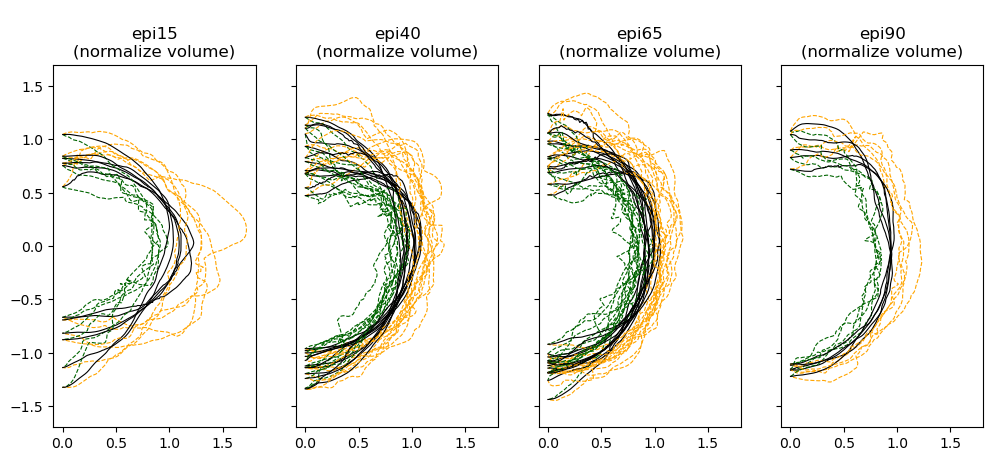

In [39]:
# plot stage averages
fig, axs = plt.subplots(1, ngroups, figsize=(ngroups*3,14), sharey = True, sharex = True)

for (k, (grp, df_stage)) in enumerate(df.groupby(groupname)):
    

    ax = axs[k]
    ax.set_title(f'\n{grp}\n(normalize volume)')
    ax.set_aspect("equal")
    ax.set_ylim(-1.7,1.7)
    
    for fn in df_stage.path.values:
        plot_all_boundaries(ax, load_rescaled_data(fn)) 

plt.savefig(outputdir / (prefix + "sections.png"))
plt.show()

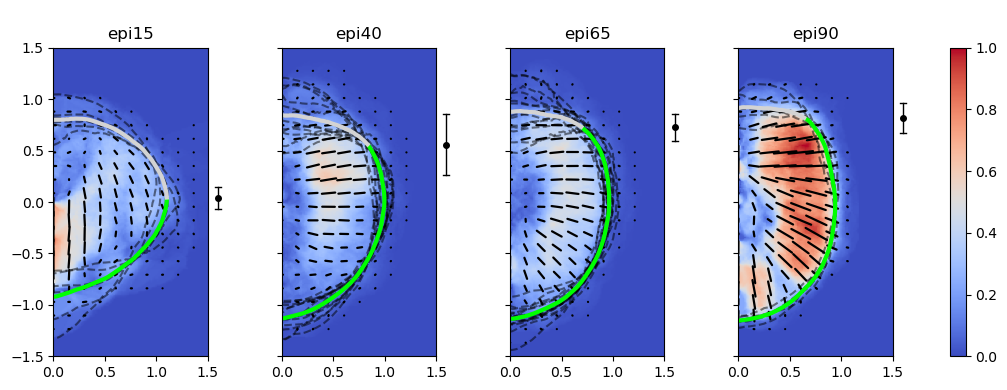

In [40]:
fig, axs = plt.subplots(1,ngroups, figsize=(3*ngroups,4), sharex=True, sharey=True)

vmax = np.max([np.max(norm(nematic_field, axis = -1)) for (group, nematic_field) in group_mean.items()])

for (k, (group, nematic_field)) in enumerate(group_mean.items()):
    
    ax = axs[k]
    ax.set_title(f'\n{group}')

    norms = norm(nematic_field, axis = -1) / vmax  # this norm is computed using the 3D vectors!

    im = ax.imshow(norms.T, extent=[*xspan, *yspan], origin='lower', cmap='coolwarm', vmax = 1.0, vmin = 0.0)
    plot_axes(ax, xs_unif, ys_unif, nematic_field)

    # cut plane heights: 
    df_stage = df.loc[df[groupname] == group]

    # for stage_data in df_stage.data.values:
    #     ax.hlines([stage_data["cut_plane_height"]], *xspan, color = "white", linestyle = ":", linewidth = 2, alpha = 0.5)

    # uncomment these lines to plot individual embryo boundaries
    for data in df.loc[df[groupname] == group].data.values:
        plot_boundary(ax, data, "avg", color = "black", alpha = 0.5, linewidth = 1.5, linestyle = "--")

    cut = np.mean([data["cut_plane_height"] for data in df_stage.data.values])
    cut_std = np.std([data["cut_plane_height"] for data in df_stage.data.values])
    cut_wdt = 0.03

    ax.plot([1.6], [cut], marker = "o", color = "black", markersize = 4, clip_on = False)
    ax.plot([1.6,1.6], [cut + cut_std, cut - cut_std], color = "black", linewidth = 1, clip_on = False)
    ax.plot([1.6-cut_wdt,1.6+cut_wdt], [cut + cut_std, cut + cut_std], color = "black", linewidth = 1, clip_on = False)
    ax.plot([1.6-cut_wdt,1.6+cut_wdt], [cut - cut_std, cut - cut_std], color = "black", linewidth = 1, clip_on = False)

    # averaged embryo boundary 
    angls, mags, X, Y  = stages_avg_boundary[group]
    mask = Y < cut
    ax.plot(X[mask], Y[mask], linewidth = 3.0, linestyle = "solid", color = "lime")
    ax.plot(X[np.logical_not(mask)], Y[np.logical_not(mask)], linewidth = 3.0, linestyle = "solid", color = "lightgray")

    ax.set_xlim(*xspan)
    ax.set_ylim(*yspan)


    # ax.vlines([x_line], *yspan, color = "white", linestyle = ":", linewidth = 2)
    # ax.vlines([y_line], *xspan, color = "white", linestyle = ":", linewidth = 2)

fig.tight_layout()
fig.colorbar(im, ax = axs)
fig.savefig(outputdir / (prefix + "nematic_averages_per_stage"))
fig.savefig(outputdir / (prefix + "nematic_averages_per_stage.pdf"))

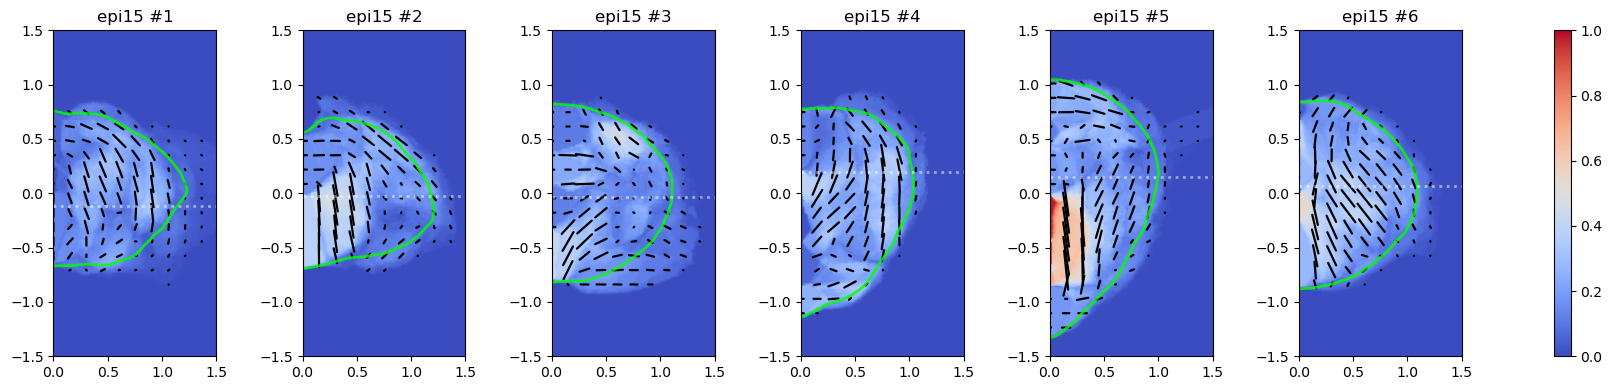

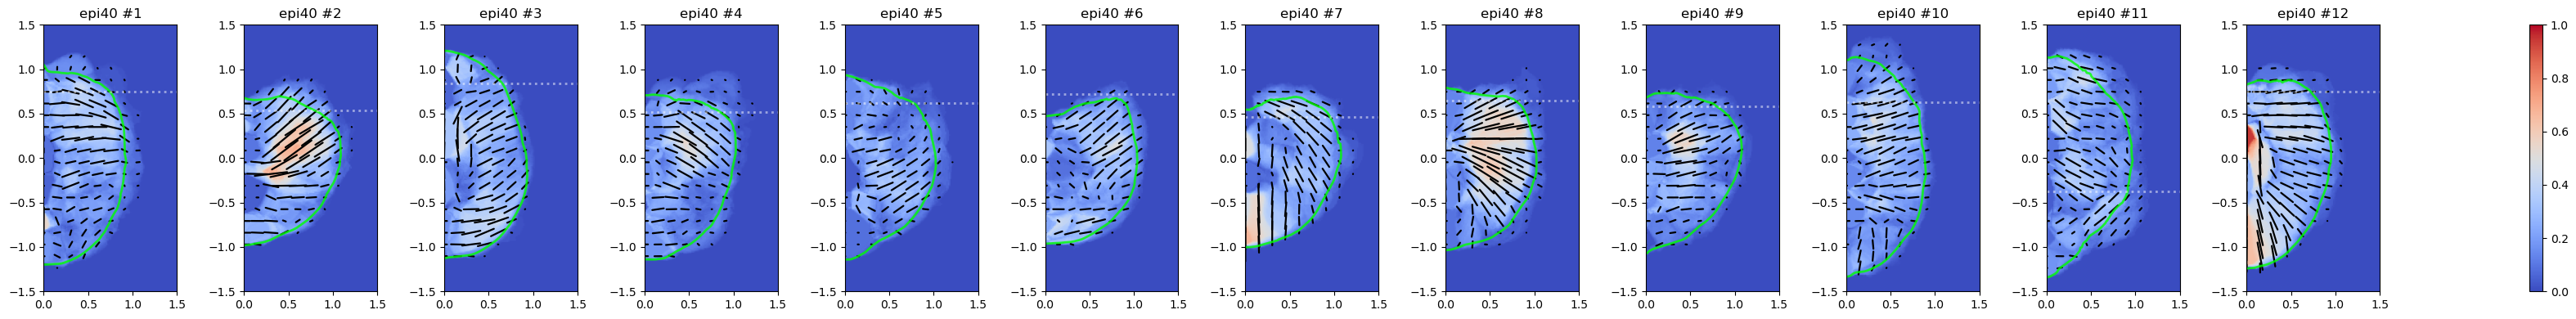

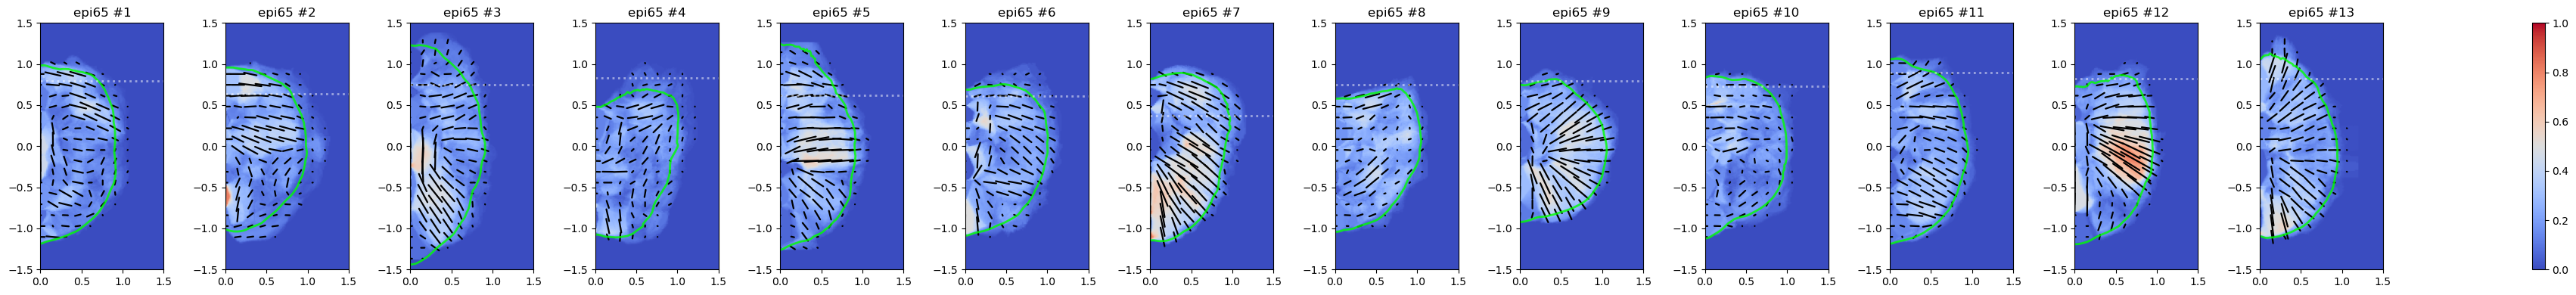

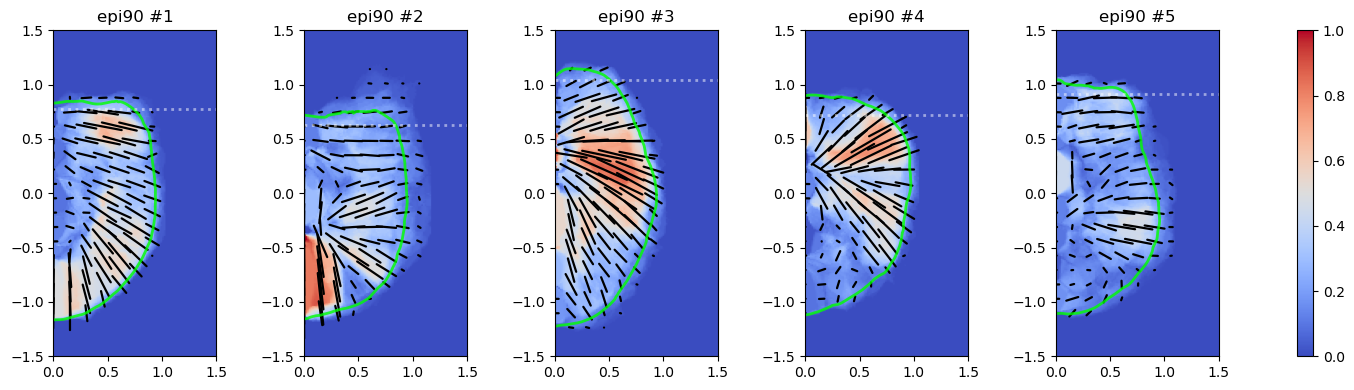

In [41]:
vmax_embryo = np.max([np.max(norm(nm,axis=-1)) for nm in df.nematic_mean.values])

for (k, (group, df_stage)) in enumerate(df.groupby(groupname)):

    n_embryo = df_stage.shape[0]

    fig, axs = plt.subplots(1, n_embryo, figsize=(1 + 3 * n_embryo,4))

    for (l, (data, nematic_field)) in enumerate(zip(df_stage.data.values, df_stage.nematic_mean.values)):
        
        ax = axs[l]
        ax.set_title(f'{group} #{l+1}')

        norms = norm(nematic_field, axis = -1) / vmax_embryo  # this norm is computed using the 3D vectors!

        im = ax.imshow(norms.T, extent=[*xspan, *yspan], origin='lower', cmap='coolwarm', vmax = 1, vmin = 0)
        plot_axes(ax, xs_unif, ys_unif, nematic_field)

        plot_boundary(ax, data, "avg", color = "lime", alpha = 0.8, linewidth = 2.0, linestyle = "solid")

        ax.hlines([data["cut_plane_height"]], *xspan, color = "white", linestyle = ":", linewidth = 2, alpha = 0.5)

        ax.set_xlim(*xspan)
        ax.set_ylim(*yspan)

    fig.tight_layout()
    fig.colorbar(im, ax = axs)
    group_fn = group.replace("/", "_")
    fig.savefig(outputdir / f"{prefix}rotational_nematic_averages_group={group_fn}.png")
    fig.savefig(outputdir / f"{prefix}rotational_nematic_averages_group={group_fn}.pdf")


In [42]:
# print summary table of id to full embryo name

# create summary table of embryo filename, embryo number in plot (e.g. 1 2 3 per stage)
per_stage_ids = [] 
df.sort_values(by = groupname, inplace = True)
for i, (stage, df_stage) in enumerate(df.groupby(groupname)):
    per_stage_ids += [j+1 for j in range(len(df_stage))]

df_ids = pd.DataFrame({"filename": [str(x).split(os.sep)[-3] for x in df.path], "type": df[groupname].values, "embryo_number": per_stage_ids})
df_ids.to_csv(outputdir / f"{prefix}embryo_ids.csv", index = False)
df_ids

,filename,type,embryo_number
0,wildtype,epi15,1
1,wildtype,epi15,2
2,wildtype,epi15,3
3,wildtype,epi15,4
4,wildtype,epi15,5
5,wildtype,epi15,6
6,wildtype,epi40,1
7,wildtype,epi40,2
8,wildtype,epi40,3
9,wildtype,epi40,4


In [43]:
df["number_of_cells"] = df.data.apply(lambda d: len(np.unique(d["cell_labels"]))-1)

vmax_embryo = np.max([np.max(norm(nm,axis=-1)) for nm in df.nematic_mean.values])
df["nematic_norm_field"] = df.nematic_mean.apply(lambda nf: norm(nf, axis = 2))
df["nematic_norm_field"] = df["nematic_norm_field"] / vmax_embryo

df["averageExpData"] = df.apply(lambda row: averageExpData(row["nematic_norm_field"].T, xs_unif, ys_unif, row["data"]["embryo_X"], row["data"]["embryo_Y"]), axis = 1)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

epi15 vs. epi40: Mann-Whitney-Wilcoxon test two-sided, P_val:5.290e-02 U_stat=1.500e+01
epi40 vs. epi65: Mann-Whitney-Wilcoxon test two-sided, P_val:7.237e-01 U_stat=8.500e+01
epi65 vs. epi90: Mann-Whitney-Wilcoxon test two-sided, P_val:9.804e-03 U_stat=7.000e+00


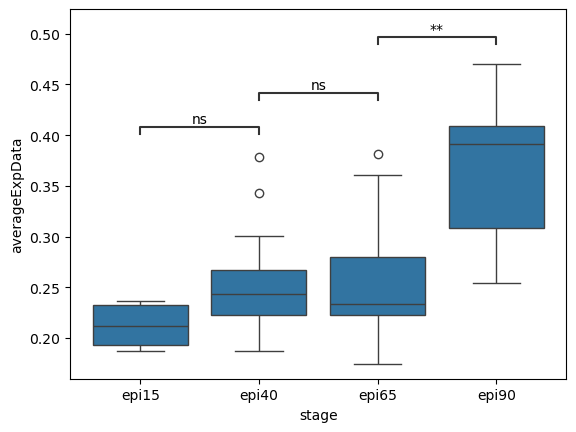

In [45]:
g = sns.boxplot(data=df, x = groupname, y = "averageExpData")

pairs=[("epi15", "epi40"), ("epi40", "epi65"), ("epi65", "epi90")]

annotator = Annotator(g, pairs, data=df, x="stage", y="averageExpData", order=["epi15", "epi40", "epi65", "epi90"])
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside')
annotator.apply_and_annotate()

plt.savefig(outputdir / f"{prefix}{groupname}_vs_avg_order_boxplot.pdf")
plt.savefig(outputdir / f"{prefix}{groupname}_vs_avg_order_boxplot.png")

In [46]:
df_avg = df.loc[:, (groupname, "averageExpData", "number_of_cells")]
df_avg.to_csv(outputdir / f"{prefix}averageExpData.csv")